In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_completed_csv(path_csv: str):
    df = pd.read_csv(path_csv, index_col=0)
    labels = list(df.columns)
    M = df.values.astype(float)
    return M, labels

def sanitize_distance_matrix(D: np.ndarray, force_nonneg: bool=True) -> np.ndarray:
    M = np.array(D, dtype=float)
    n = M.shape[0]
    # replace non-finite with median off-diagonal
    off = ~np.eye(n, dtype=bool)
    v = M[off]
    med = np.nanmedian(v[np.isfinite(v)]) if np.isfinite(v).any() else 1.0
    M = np.nan_to_num(M, nan=med, posinf=med, neginf=med)
    # symmetrize
    M = 0.5 * (M + M.T)
    if force_nonneg:
        M = np.maximum(M, 0.0)
    np.fill_diagonal(M, 0.0)
    return M

# -----------------------
# EDIT THESE 5 PATHS
# -----------------------
files = [
        "Result_NW_15x15.txt",
    "HybAdamUM_completed_p50_rep2.csv",
     "MWstar_completed_p50_rep2.csv",
    "LRMC_completed_p50_rep2",
    "NJstar_STRICT_completed_p50_rep2.csv",
]

titles = [f"Rep {i}" for i in range(1, 6)]
suptitle = "Hyb-Adam-UM completed matrices (50% missing) — 5 replicates"

# -----------------------
# LOAD + VALIDATE
# -----------------------
mats, labels0 = [], None
for p in files:
    if not os.path.exists(p):
        raise FileNotFoundError(f"Missing file: {p}")
    M, labels = load_completed_csv(p)
    M = sanitize_distance_matrix(M)
    if labels0 is None:
        labels0 = labels
    elif labels != labels0:
        raise ValueError(f"Label order mismatch in {p}. Ensure identical column order across replicates.")
    mats.append(M)

# shared color limits across all panels
vmin = min(float(np.min(M)) for M in mats)
vmax = max(float(np.max(M)) for M in mats)

# -----------------------
# PLOT: 1 ROW, 5 PANELS, 1 COLORBAR
# -----------------------
fig, axes = plt.subplots(1, 5, figsize=(20, 4.2), constrained_layout=True)
im_last = None

for ax, M, t in zip(axes, mats, titles):
    im_last = ax.imshow(M, interpolation="nearest", vmin=vmin, vmax=vmax, aspect="auto")
    ax.set_title(t, fontsize=11)
    ax.set_xticks(range(len(labels0)))
    ax.set_yticks(range(len(labels0)))
    ax.set_xticklabels(labels0, rotation=90, fontsize=6)
    ax.set_yticklabels(labels0, fontsize=6)

# one shared colorbar on the right
cbar = fig.colorbar(im_last, ax=axes, shrink=0.95, pad=0.02)
cbar.set_label("Distance")

fig.suptitle(suptitle, fontsize=13)
plt.show()

# optional save
fig.savefig("heatmap_row_5rep.png", dpi=300, bbox_inches="tight")
print("Saved: heatmap_row_5rep.png")


IndexError: boolean index did not match indexed array along dimension 1; dimension is 0 but corresponding boolean dimension is 14

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_distance_csv_robust(path_csv: str):
    """
    Load a square distance matrix from CSV, robust to delimiter/extra columns.
    Returns (M, labels).
    """
    if not os.path.exists(path_csv):
        raise FileNotFoundError(path_csv)

    last_err = None
    for sep in [",", ";", "\t"]:
        try:
            df = pd.read_csv(path_csv, index_col=0, sep=sep, engine="python")
            # coerce to numeric; non-numeric -> NaN
            df_num = df.apply(pd.to_numeric, errors="coerce")

            # Drop columns that are entirely NaN (common if parsing went wrong)
            df_num = df_num.dropna(axis=1, how="all")
            # Drop rows that are entirely NaN
            df_num = df_num.dropna(axis=0, how="all")

            # Some files may have an extra unnamed column after index_col=0
            # or may have duplicated index labels; neither is fatal for numeric matrix extraction.
            M = df_num.values.astype(float)
            labels = list(df_num.columns)

            # Basic sanity: must have columns
            if M.shape[1] == 0:
                last_err = ValueError(f"Parsed 0 numeric columns with sep='{sep}'")
                continue

            return M, labels, sep
        except Exception as e:
            last_err = e
            continue

    raise ValueError(f"Failed to parse {path_csv}. Last error: {last_err}")

def sanitize_distance_matrix(D: np.ndarray, force_nonneg: bool=True) -> np.ndarray:
    M = np.array(D, dtype=float)
    if M.ndim != 2:
        raise ValueError(f"Matrix must be 2D, got shape {M.shape}")

    n, m = M.shape
    if n != m:
        raise ValueError(f"Matrix must be square, got shape {M.shape}")

    off = ~np.eye(n, dtype=bool)
    v = M[off]
    finite = np.isfinite(v)
    med = float(np.nanmedian(v[finite])) if finite.any() else 1.0

    M = np.nan_to_num(M, nan=med, posinf=med, neginf=med)
    M = 0.5 * (M + M.T)

    if force_nonneg:
        M = np.maximum(M, 0.0)

    np.fill_diagonal(M, 0.0)
    return M

# -----------------------
# EDIT THESE 5 PATHS
# -----------------------
files = [
        "Result_NW_15x15.txt",
    "HybAdamUM_completed_p50_rep2.csv",
     "MWstar_completed_p50_rep2.csv",
    "LRMC_completed_p50_rep2",
    "NJstar_STRICT_completed_p50_rep2.csv",
]

titles = [f"Rep {i}" for i in range(1, 6)]
suptitle = "Hyb-Adam-UM completed matrices (50% missing) — 5 replicates"

# -----------------------
# LOAD + VALIDATE (with prints)
# -----------------------
mats, labels0 = [], None

print("Loading files:")
for p in files:
    M_raw, labels, sep_used = load_distance_csv_robust(p)
    print(f"  {os.path.basename(p)} | sep='{sep_used}' | raw shape={M_raw.shape}")

    M = sanitize_distance_matrix(M_raw)

    if labels0 is None:
        labels0 = labels
    else:
        # If labels mismatch, we can reindex to labels0 if possible
        if labels != labels0:
            # attempt realignment
            df = pd.DataFrame(M, index=labels, columns=labels)
            missing = set(labels0) - set(labels)
            if missing:
                raise ValueError(f"Labels mismatch in {p}. Missing labels: {sorted(missing)}")
            df = df.loc[labels0, labels0]
            M = df.values
            print(f"    labels realigned to reference order; new shape={M.shape}")

    mats.append(M)

# shared color limits
vmin = min(float(np.min(M)) for M in mats)
vmax = max(float(np.max(M)) for M in mats)

# -----------------------
# PLOT: 1 ROW, 5 PANELS, 1 COLORBAR
# -----------------------
fig, axes = plt.subplots(1, 5, figsize=(20, 4.2), constrained_layout=True)
im_last = None

for ax, M, t in zip(axes, mats, titles):
    im_last = ax.imshow(M, interpolation="nearest", vmin=vmin, vmax=vmax, aspect="auto")
    ax.set_title(t, fontsize=11)
    ax.set_xticks(range(len(labels0)))
    ax.set_yticks(range(len(labels0)))
    ax.set_xticklabels(labels0, rotation=90, fontsize=6)
    ax.set_yticklabels(labels0, fontsize=6)

cbar = fig.colorbar(im_last, ax=axes, shrink=0.95, pad=0.02)
cbar.set_label("Distance")

fig.suptitle(suptitle, fontsize=13)
plt.show()

fig.savefig("heatmap_row_5rep.png", dpi=300, bbox_inches="tight")
print("Saved: heatmap_row_5rep.png")


Loading files:
  Hyb-Adam-UM_completed_p50_rep2.csv | sep=',' | raw shape=(15, 15)
  KNN_k12_completed_p50_rep2.csv | sep=',' | raw shape=(15, 15)
  LRMC_Custom_completed_p50_rep2.csv | sep=',' | raw shape=(15, 15)
  patristic_ET-Impute_rep2.csv | sep=',' | raw shape=(15, 15)


ValueError: Failed to parse Result_NW_15x15.txt. Last error: Parsed 0 numeric columns with sep='	'

Loading:
  Result_NW_15x15.txt | txt | raw shape=(15, 15)
  Hyb-Adam-UM_completed_p50_rep2.csv | csv(sep=',') | raw shape=(15, 15)
  KNN_k12_completed_p50_rep2.csv | csv(sep=',') | raw shape=(15, 15)
  patristic_ET-Impute_rep2.csv | csv(sep=',') | raw shape=(15, 15)
  LRMC_Custom_completed_p50_rep2.csv | csv(sep=',') | raw shape=(15, 15)


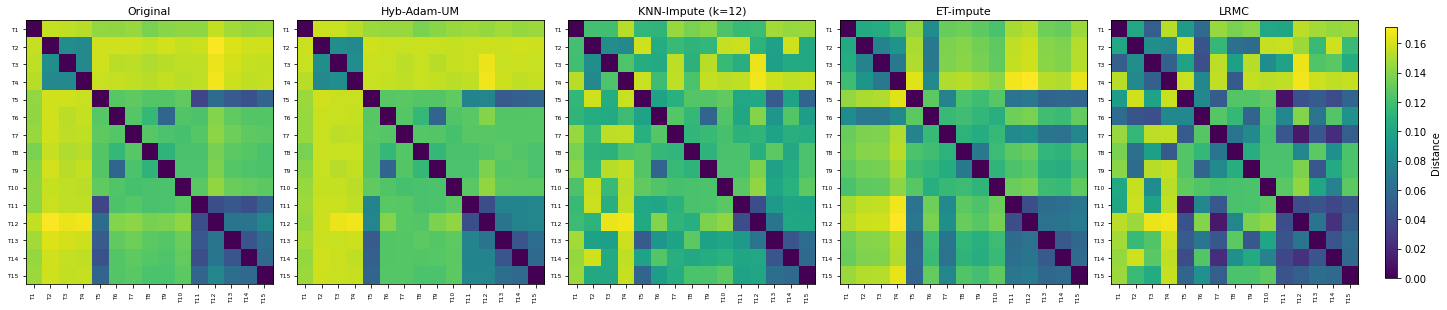

Saved: heatmap_row_joined.png


In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_matrix_any(path: str, fallback_labels=None):
    """
    Loads either:
      - CSV square matrix with row index + column headers
      - TXT whitespace-delimited numeric square matrix (no labels)
    Returns (M, labels, source_type)
    """
    ext = os.path.splitext(path)[1].lower()

    if ext in [".txt", ".dat"]:
        M = np.loadtxt(path, dtype=float)
        if M.ndim != 2:
            raise ValueError(f"{path}: expected 2D matrix, got shape {M.shape}")
        n, m = M.shape
        if n != m:
            raise ValueError(f"{path}: expected square matrix, got shape {M.shape}")
        if fallback_labels is None:
            labels = [f"t{i+1}" for i in range(n)]
        else:
            if len(fallback_labels) != n:
                raise ValueError(
                    f"{path}: label length {len(fallback_labels)} does not match matrix size {n}"
                )
            labels = list(fallback_labels)
        return M, labels, "txt"

    if ext == ".csv":
        # robust-ish CSV read: try common separators
        last_err = None
        for sep in [",", ";", "\t"]:
            try:
                df = pd.read_csv(path, index_col=0, sep=sep, engine="python")
                df = df.apply(pd.to_numeric, errors="coerce")
                df = df.dropna(axis=1, how="all").dropna(axis=0, how="all")
                M = df.values.astype(float)
                labels = list(df.columns)
                if M.shape[1] == 0:
                    last_err = ValueError(f"Parsed 0 numeric columns with sep='{sep}'")
                    continue
                return M, labels, f"csv(sep='{sep}')"
            except Exception as e:
                last_err = e
                continue
        raise ValueError(f"Failed to parse CSV {path}. Last error: {last_err}")

    raise ValueError(f"Unsupported file extension for {path}")

def sanitize_distance_matrix(D: np.ndarray, force_nonneg: bool=True) -> np.ndarray:
    M = np.array(D, dtype=float)
    if M.ndim != 2:
        raise ValueError(f"Matrix must be 2D, got shape {M.shape}")
    n, m = M.shape
    if n != m:
        raise ValueError(f"Matrix must be square, got shape {M.shape}")

    off = ~np.eye(n, dtype=bool)
    v = M[off]
    finite = np.isfinite(v)
    med = float(np.nanmedian(v[finite])) if finite.any() else 1.0

    M = np.nan_to_num(M, nan=med, posinf=med, neginf=med)
    M = 0.5 * (M + M.T)
    if force_nonneg:
        M = np.maximum(M, 0.0)
    np.fill_diagonal(M, 0.0)
    return M

# -----------------------
# EDIT: put EXACTLY the 5 files you want to plot in one line
# (If one of them is Result_NW_15x15.txt, that is fine now.)
# -----------------------
files = [
    "Result_NW_15x15.txt",
    "Hyb-Adam-UM_completed_p50_rep2.csv",
    "KNN_k12_completed_p50_rep2.csv",
     "patristic_ET-Impute_rep2.csv",
    "LRMC_Custom_completed_p50_rep2.csv",
]
titles = ["Original", "Hyb-Adam-UM", "KNN-Impute (k=12)","ET-impute", "LRMC"  ]

# -----------------------
# LOAD (use first labeled CSV as label source)
# -----------------------
print("Loading:")
label_source = None
for p in files:
    if p.lower().endswith(".csv"):
        M0, labels0, src0 = load_matrix_any(p)
        label_source = labels0
        break

mats = []
labels_ref = None

for p in files:
    M_raw, labels, src = load_matrix_any(p, fallback_labels=label_source)
    print(f"  {os.path.basename(p)} | {src} | raw shape={M_raw.shape}")

    M = sanitize_distance_matrix(M_raw)

    if labels_ref is None:
        labels_ref = labels
    else:
        # if labels differ, try to realign (for CSV-labeled matrices)
        if labels != labels_ref and p.lower().endswith(".csv"):
            df = pd.DataFrame(M, index=labels, columns=labels)
            missing = set(labels_ref) - set(labels)
            if missing:
                raise ValueError(f"{p}: missing labels {sorted(missing)}")
            df = df.loc[labels_ref, labels_ref]
            M = df.values
            labels = labels_ref

    mats.append(M)

# shared color scale
vmin = min(float(np.min(M)) for M in mats)
vmax = max(float(np.max(M)) for M in mats)

# -----------------------
# PLOT: 1 ROW, N PANELS, 1 COLORBAR
# -----------------------
n = len(mats)
fig, axes = plt.subplots(1, n, figsize=(4.0*n, 4.2), constrained_layout=True)
if n == 1:
    axes = [axes]

im_last = None
for ax, M, t in zip(axes, mats, titles):
    im_last = ax.imshow(M, interpolation="nearest", vmin=vmin, vmax=vmax, aspect="auto")
    ax.set_title(t, fontsize=11)
    ax.set_xticks(range(len(labels_ref)))
    ax.set_yticks(range(len(labels_ref)))
    ax.set_xticklabels(labels_ref, rotation=90, fontsize=6)
    ax.set_yticklabels(labels_ref, fontsize=6)

cbar = fig.colorbar(im_last, ax=axes, shrink=0.95, pad=0.02)
cbar.set_label("Distance")

plt.show()
fig.savefig("heatmap_row_joined.png", dpi=300, bbox_inches="tight")
print("Saved: heatmap_row_joined.png")


Loading:
  Result_NW_15x15.txt | txt | raw shape=(15, 15)
  HybAdamUM_completed_p50_rep2.csv | csv(sep=',') | raw shape=(15, 15)
  MWstar_completed_p50_rep2.csv | csv(sep=',') | raw shape=(15, 15)
  LRMC_completed_p50_rep2.csv | csv(sep=',') | raw shape=(15, 15)
  NJstar_STRICT_completed_p50_rep2.csv | csv(sep=',') | raw shape=(15, 15)


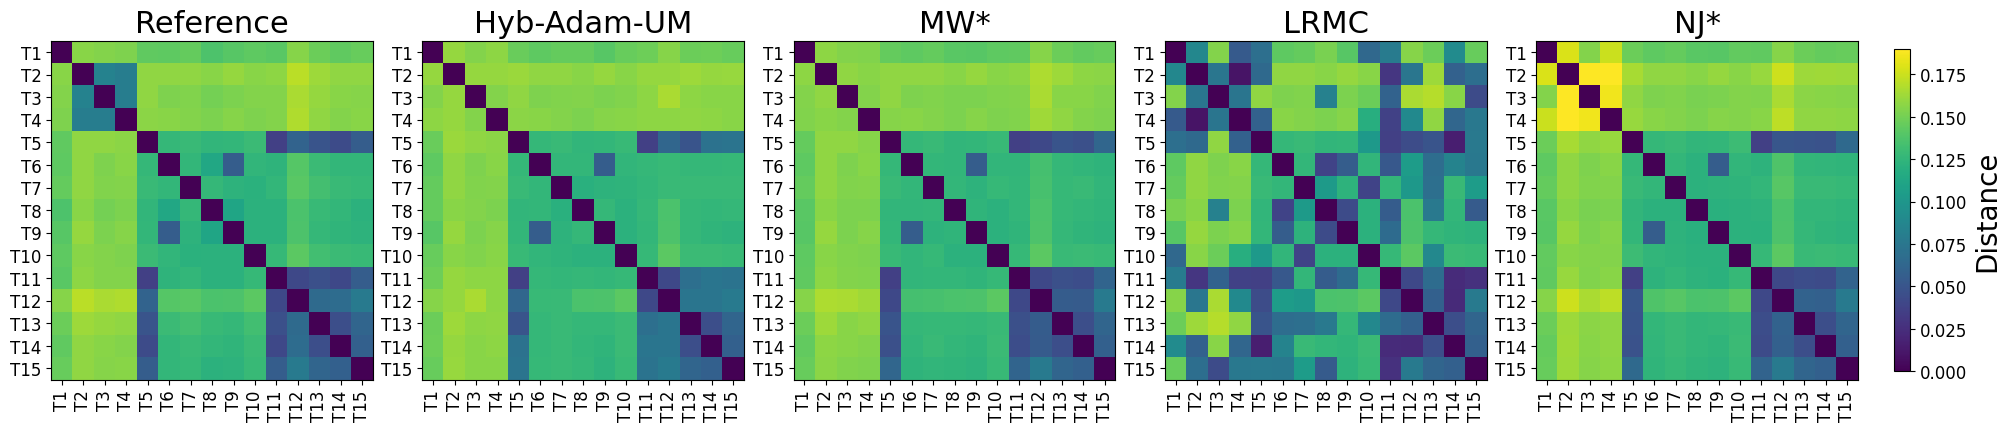

Saved: heatmap_row_joined.png


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# MAKE ALL TEXT 2× BIGGER
# =========================
FONT_SCALE = 2.0

BASE_TITLE_FS = 11
BASE_TICKLABEL_FS = 6
BASE_CBAR_LABEL_FS = 10

TITLE_FS = BASE_TITLE_FS * FONT_SCALE
TICKLABEL_FS = BASE_TICKLABEL_FS * FONT_SCALE
CBAR_LABEL_FS = BASE_CBAR_LABEL_FS * FONT_SCALE

# Also scale global defaults (helps colorbar ticks, etc.)
plt.rcParams.update({
    "font.size": 10 * FONT_SCALE,
    "axes.titlesize": TITLE_FS,
    "axes.labelsize": 10 * FONT_SCALE,
    "xtick.labelsize": TICKLABEL_FS,
    "ytick.labelsize": TICKLABEL_FS,
})

def load_matrix_any(path: str, fallback_labels=None):
    """
    Loads either:
      - CSV square matrix with row index + column headers
      - TXT whitespace-delimited numeric square matrix (no labels)
    Returns (M, labels, source_type)
    """
    ext = os.path.splitext(path)[1].lower()

    if ext in [".txt", ".dat"]:
        M = np.loadtxt(path, dtype=float)
        if M.ndim != 2:
            raise ValueError(f"{path}: expected 2D matrix, got shape {M.shape}")
        n, m = M.shape
        if n != m:
            raise ValueError(f"{path}: expected square matrix, got shape {M.shape}")
        if fallback_labels is None:
            labels = [f"t{i+1}" for i in range(n)]
        else:
            if len(fallback_labels) != n:
                raise ValueError(
                    f"{path}: label length {len(fallback_labels)} does not match matrix size {n}"
                )
            labels = list(fallback_labels)
        return M, labels, "txt"

    if ext == ".csv":
        last_err = None
        for sep in [",", ";", "\t"]:
            try:
                df = pd.read_csv(path, index_col=0, sep=sep, engine="python")
                df = df.apply(pd.to_numeric, errors="coerce")
                df = df.dropna(axis=1, how="all").dropna(axis=0, how="all")
                M = df.values.astype(float)
                labels = list(df.columns)
                if M.shape[1] == 0:
                    last_err = ValueError(f"Parsed 0 numeric columns with sep='{sep}'")
                    continue
                return M, labels, f"csv(sep='{sep}')"
            except Exception as e:
                last_err = e
                continue
        raise ValueError(f"Failed to parse CSV {path}. Last error: {last_err}")

    raise ValueError(f"Unsupported file extension for {path}")

def sanitize_distance_matrix(D: np.ndarray, force_nonneg: bool=True) -> np.ndarray:
    M = np.array(D, dtype=float)
    if M.ndim != 2:
        raise ValueError(f"Matrix must be 2D, got shape {M.shape}")
    n, m = M.shape
    if n != m:
        raise ValueError(f"Matrix must be square, got shape {M.shape}")

    off = ~np.eye(n, dtype=bool)
    v = M[off]
    finite = np.isfinite(v)
    med = float(np.nanmedian(v[finite])) if finite.any() else 1.0

    M = np.nan_to_num(M, nan=med, posinf=med, neginf=med)
    M = 0.5 * (M + M.T)
    if force_nonneg:
        M = np.maximum(M, 0.0)
    np.fill_diagonal(M, 0.0)
    return M

# -----------------------
# EDIT: put EXACTLY the 5 files you want to plot in one line
# -----------------------
files = [
        "Result_NW_15x15.txt",
    "HybAdamUM_completed_p50_rep2.csv",
     "MWstar_completed_p50_rep2.csv",
    "LRMC_completed_p50_rep2.csv",
    "NJstar_STRICT_completed_p50_rep2.csv",
]
titles = ["Reference", "Hyb-Adam-UM", "MW*", "LRMC", "NJ*"]

# -----------------------
# LOAD (use first labeled CSV as label source)
# -----------------------
print("Loading:")
label_source = None
for p in files:
    if p.lower().endswith(".csv"):
        M0, labels0, src0 = load_matrix_any(p)
        label_source = labels0
        break

mats = []
labels_ref = None

for p in files:
    M_raw, labels, src = load_matrix_any(p, fallback_labels=label_source)
    print(f"  {os.path.basename(p)} | {src} | raw shape={M_raw.shape}")

    M = sanitize_distance_matrix(M_raw)

    if labels_ref is None:
        labels_ref = labels
    else:
        if labels != labels_ref and p.lower().endswith(".csv"):
            df = pd.DataFrame(M, index=labels, columns=labels)
            missing = set(labels_ref) - set(labels)
            if missing:
                raise ValueError(f"{p}: missing labels {sorted(missing)}")
            df = df.loc[labels_ref, labels_ref]
            M = df.values
            labels = labels_ref

    mats.append(M)

# shared color scale
vmin = min(float(np.min(M)) for M in mats)
vmax = max(float(np.max(M)) for M in mats)

# -----------------------
# PLOT: 1 ROW, N PANELS, 1 COLORBAR
# -----------------------
n = len(mats)
fig, axes = plt.subplots(1, n, figsize=(4.0*n, 4.2), constrained_layout=True)
if n == 1:
    axes = [axes]

im_last = None
for ax, M, t in zip(axes, mats, titles):
    im_last = ax.imshow(M, interpolation="nearest", vmin=vmin, vmax=vmax, aspect="auto")
    ax.set_title(t, fontsize=TITLE_FS)
    ax.set_xticks(range(len(labels_ref)))
    ax.set_yticks(range(len(labels_ref)))
    ax.set_xticklabels(labels_ref, rotation=90, fontsize=TICKLABEL_FS)
    ax.set_yticklabels(labels_ref, fontsize=TICKLABEL_FS)

cbar = fig.colorbar(im_last, ax=axes, shrink=0.95, pad=0.02)
cbar.set_label("Distance", fontsize=CBAR_LABEL_FS)
cbar.ax.tick_params(labelsize=TICKLABEL_FS)

plt.show()
fig.savefig("heatmap_row_joined.png", dpi=600, bbox_inches="tight")
print("Saved: heatmap_row_joined.png")

